# Pipeline

In [1]:
from train_pipeline import train

# cfg

In [2]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

In [3]:
from IPython.display import clear_output

In [4]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    f"model.encoding_size={64}",
    f"model.hidden_layers={3}",
    'image=cameraman',
    'model.m=1',
    'logging.experiment_name="splitnet_posenc__nlayers=${model.hidden_layers}"',
    "+device=cuda:1",
])

print(OmegaConf.to_yaml(cfg))

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.splitnet.SplitNetPosEnc
  in_features: 2
  encoding_size: 64
  hidden_features: 128
  hidden_layers: 3
  outermost_linear: false
  m: 1
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__nlayers=${model.hidden_layers}
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1



In [5]:
cfg.model

{'_target_': 'spellbook.splitnet.SplitNetPosEnc', 'in_features': 2, 'encoding_size': 64, 'hidden_features': 128, 'hidden_layers': 3, 'outermost_linear': False, 'm': 1}

In [6]:
import rff

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import math
from tqdm.auto import tqdm

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2, device='cpu'):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen, device=device)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

import plotly.express as px
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a


def U(*shape, r=1):
    x = torch.rand(*shape)
    
    x = (x-0.5)*(2*r)
    return x


import lovely_tensors as lt
lt.monkey_patch()

In [7]:
from spellbook.splitnet import plot_acts

In [8]:
def init_siren(W, fan_in, omega=30, init_c=24, flic=2, is_first=False):
    if is_first:
        c = flic / fan_in
    else:
        c = np.sqrt(init_c / fan_in) / omega    
    W.uniform_(-c, c)

In [160]:
from spellbook.splitnet import plot_distributions

In [76]:
import torch
from torch import nn
import torch.nn.functional as F

import os
import math


class SplitLayerOmegas(nn.Module):
    def __init__(self, input_dim, output_dim, m=1., omegas=(1,1,1.,1)):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim * 4)
        self.m = m
        self.omegas = omegas

    def forward(self, x):
        h, acts = self.forward_with_activations(x)
        return h

    def forward_with_activations(self, x):
        preact = self.linear(x)
        preacts = preact.chunk(4, dim=-1)
        preacts = list(preacts)
    
        for i in range(len(preacts)):
            preacts[i] = self.omegas[i] * preacts[i]

        preact_tanh, preact_sigmoid, preact_sin, preact_cos = preacts
        act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(),preact_sin.sin(), preact_cos.cos()
        h = act_tanh * act_sigmoid * act_sin * act_cos
        
        h = h * self.m

        return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

class SplitNetPosEncOmegas(nn.Module):
    def __init__(self, 
                 in_features=2,
                 encoding_size=64,
                 hidden_features=64, 
                 hidden_layers=1, 
                 out_features=1, 
                 outermost_linear=True,
                 m=1.,
                 omegas=(1,1,1.,1),
                 init_fn=None,
                 ):
        super().__init__()
        if not hasattr(m, '__len__'):
            m = [m] * (hidden_layers+2)
            
        is_layerwise_omegas = hasattr(omegas[0], '__len__')
        
        if not is_layerwise_omegas:
            omegas = [omegas] * (hidden_layers+2)
            

        import rff
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=in_features, encoded_size=encoding_size)
        self.net = []

        self.net += [SplitLayerOmegas(encoding_size*2, hidden_features, m=m[0], omegas=omegas[0])]
        self.net += [SplitLayerOmegas(hidden_features, hidden_features, m=m[i+1], omegas=omegas[i+1]) for i in range(hidden_layers)]

        if outermost_linear:
            self.net += [nn.Linear(hidden_features, out_features)]
        else:
            self.net += [SplitLayerOmegas(hidden_features, out_features, omegas=omegas[-1], m=m[-1])]

        self.net = nn.Sequential(*self.net)
        self.outermost_linear = outermost_linear
        self.omegas = omegas
        
        if init_fn == "my_init_02":
            my_init_02(self)
        elif init_fn == 'my_init_03':
            my_init_03(self)
        elif init_fn is not None:
            raise ArgumentError(f"Unknown init_fn: {init_fn}")

    def forward(self, x):
        x = self.encoding(x)
        return self.net(x)

    def forward_with_activations(self, x):
        x = self.encoding(x)
        h = x
        intermediate_acts = []

        for layer in self.net:
            if isinstance(layer, SplitLayerOmegas):
                h, acts = layer.forward_with_activations(h)
            else:
                h = layer(h)
                acts = []

            intermediate_acts.append((h, acts))

        return h, intermediate_acts

    


In [167]:
mega_omegas = [
    (5/1.323, 15/0.78213, 9/1.2, 10),
    (15, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
]

giga_omegas = [
    [0.12014468014240265, 0.6008497476577759, 0.2702421545982361, 0.2616932690143585],
    [0.5118758678436279, 1.9711511135101318, 0.7647950053215027, 0.7527167201042175],
    [2.7775514125823975, 9.462844848632812, 3.237828016281128, 3.223662853240967],
    [18.891096115112305, 60.468223571777344, 18.257936477661133, 18.576128005981445],
    [12.317709922790527, 39.97261428833008, 11.623711585998535, 11.119503021240234],
]

In [175]:
model_kwargs

{'in_features': 2,
 'encoding_size': 64,
 'hidden_features': 128,
 'hidden_layers': 3,
 'omegas': [[0.12014468014240265,
   0.6008497476577759,
   0.2702421545982361,
   0.2616932690143585],
  [0.5118758678436279,
   1.9711511135101318,
   0.7647950053215027,
   0.7527167201042175],
  [2.7775514125823975,
   9.462844848632812,
   3.237828016281128,
   3.223662853240967],
  [18.891096115112305,
   60.468223571777344,
   18.257936477661133,
   18.576128005981445],
  [12.317709922790527,
   39.97261428833008,
   11.623711585998535,
   11.119503021240234]],
 'outermost_linear': False,
 'm': 10.0}

In [168]:
model_kwargs = {'in_features': 2, 
                'encoding_size': 64, 
                'hidden_features': 128, 
                'hidden_layers': 3, 
                'omegas': giga_omegas,
                # 'omegas': (1,1,30,30),
                'outermost_linear': False, 
                'm': 10.
}

# model = instantiate(cfg.model, out_features=1, m=[10, 10, 10,10,10])
model = SplitNetPosEncOmegas(**model_kwargs)
omegas = model.omegas



tensor[512, 128] n=65536 x∈[-1.602, 1.602] μ=-0.001 σ=0.700
tensor[512, 128] n=65536 x∈[-0.566, 0.566] μ=-0.001 σ=0.239
tensor[512, 128] n=65536 x∈[-0.134, 0.134] μ=-0.000 σ=0.056
tensor[512, 128] n=65536 x∈[-0.024, 0.024] μ=4.674e-05 σ=0.010
tensor[4, 128] n=512 x∈[-0.037, 0.037] μ=0.001 σ=0.016


In [169]:
# layer.linear.weight.data /= 10

act_tanh (2000, 128) in [-0.968, 0.966] μ=0.000 σ=0.394
act_sigmoid (2000, 128) in [0.038, 0.956] μ=0.500 σ=0.157
act_sin (2000, 128) in [-1.000, 1.000] μ=0.001 σ=0.706
act_cos (2000, 128) in [-1.000, 1.000] μ=0.151 σ=0.691


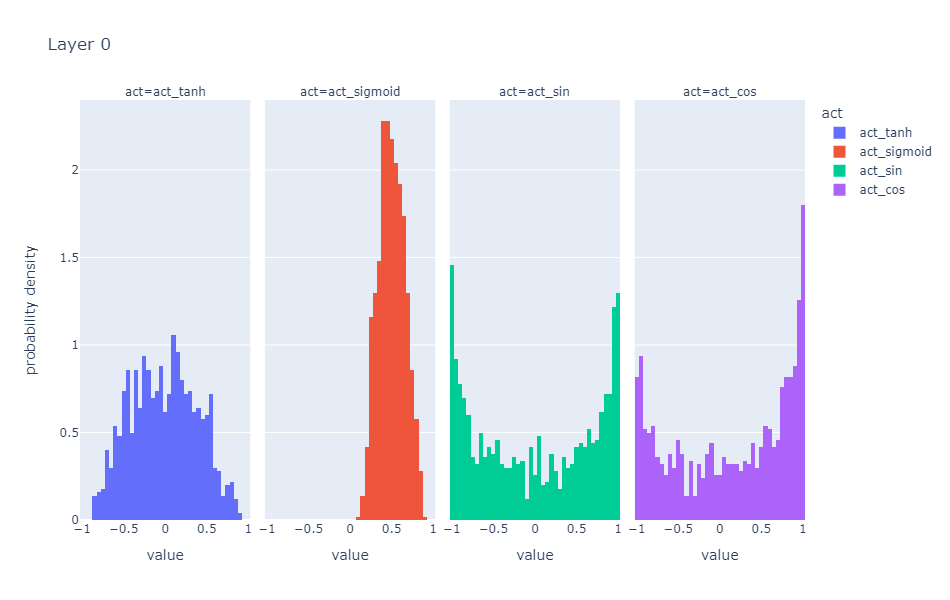

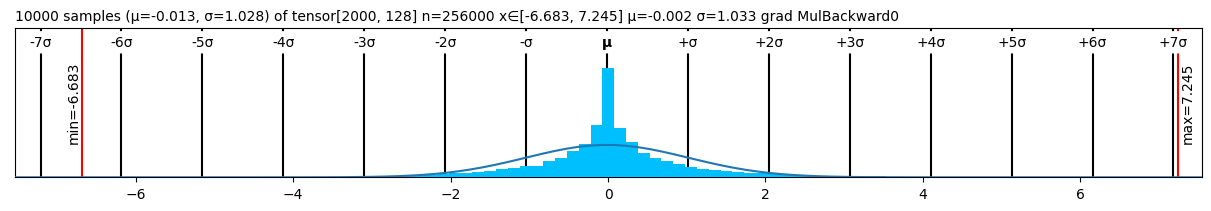

act_tanh (2000, 128) in [-0.995, 0.995] μ=-0.000 σ=0.508
act_sigmoid (2000, 128) in [0.008, 0.987] μ=0.501 σ=0.210
act_sin (2000, 128) in [-1.000, 1.000] μ=0.001 σ=0.708
act_cos (2000, 128) in [-1.000, 1.000] μ=0.019 σ=0.707


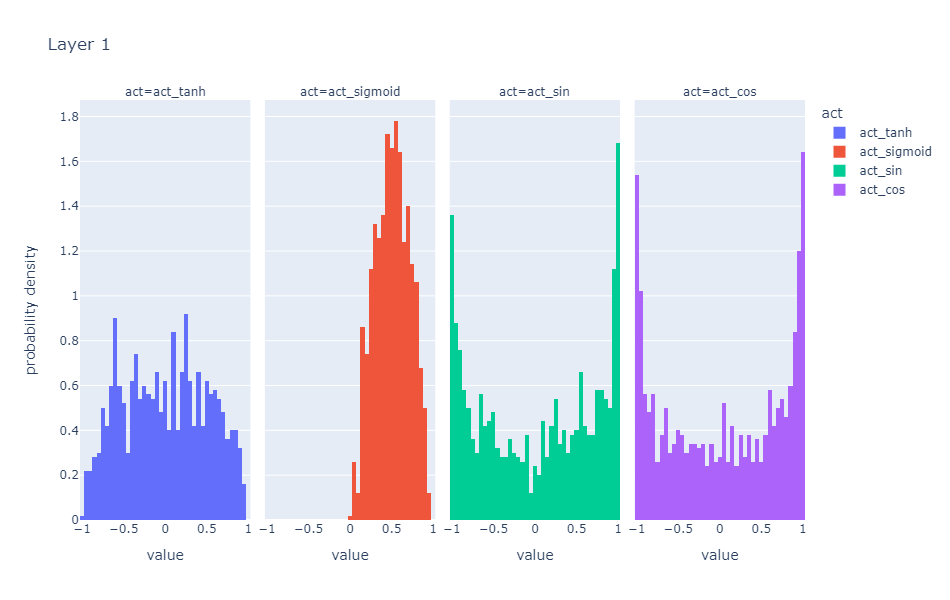

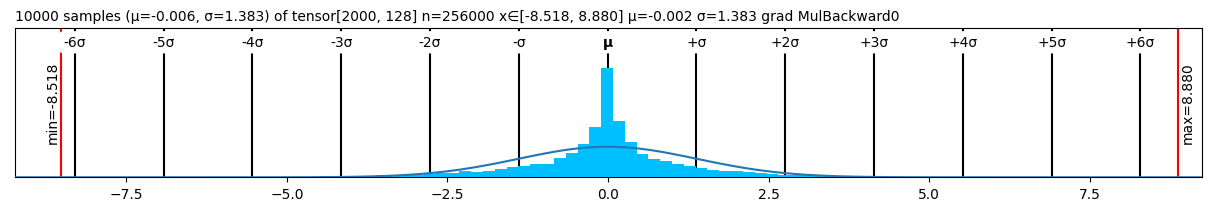

act_tanh (2000, 128) in [-1.000, 1.000] μ=-0.001 σ=0.594
act_sigmoid (2000, 128) in [0.001, 0.999] μ=0.500 σ=0.255
act_sin (2000, 128) in [-1.000, 1.000] μ=-0.001 σ=0.707
act_cos (2000, 128) in [-1.000, 1.000] μ=0.003 σ=0.708


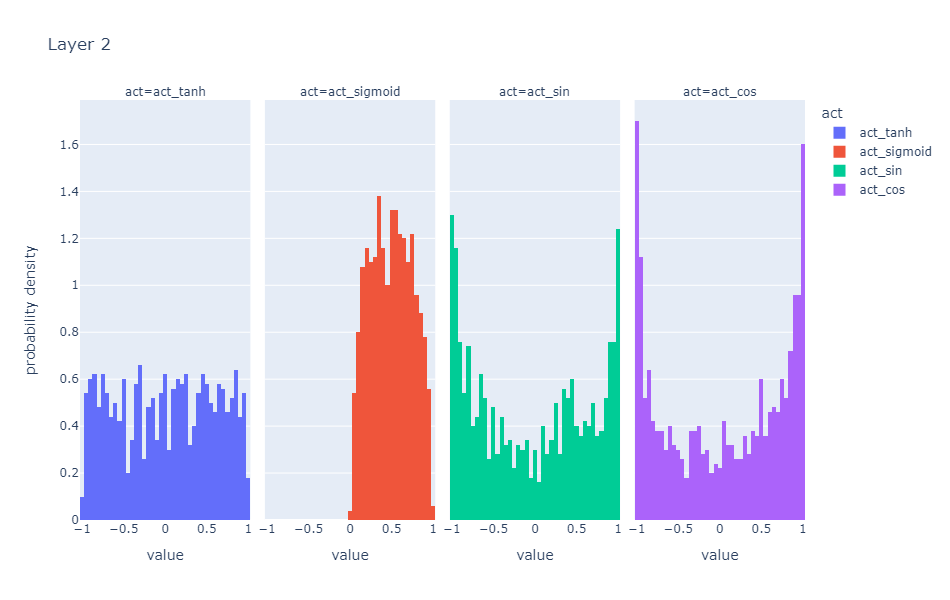

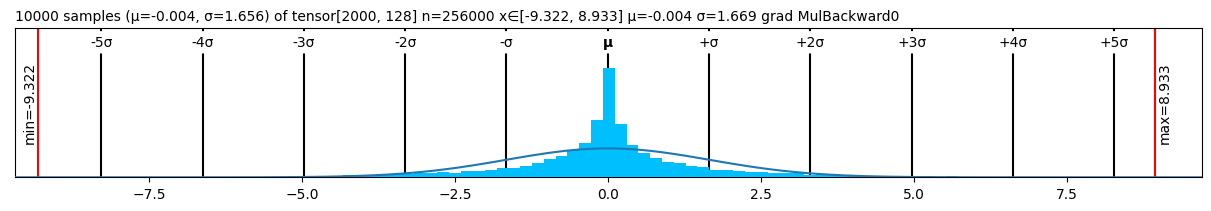

act_tanh (2000, 128) in [-1.000, 1.000] μ=0.000 σ=0.650
act_sigmoid (2000, 128) in [0.000, 0.999] μ=0.500 σ=0.284
act_sin (2000, 128) in [-1.000, 1.000] μ=0.002 σ=0.707
act_cos (2000, 128) in [-1.000, 1.000] μ=0.003 σ=0.707


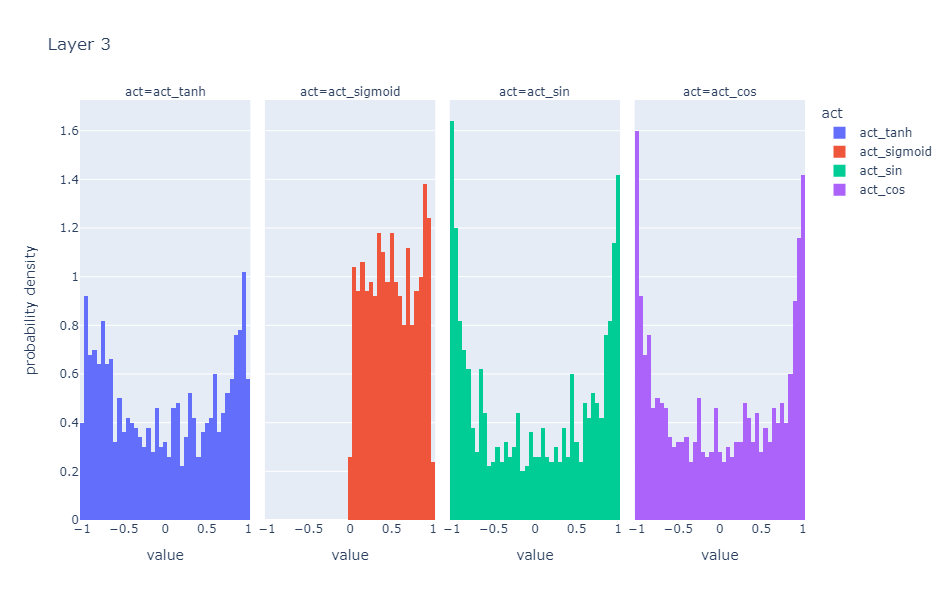

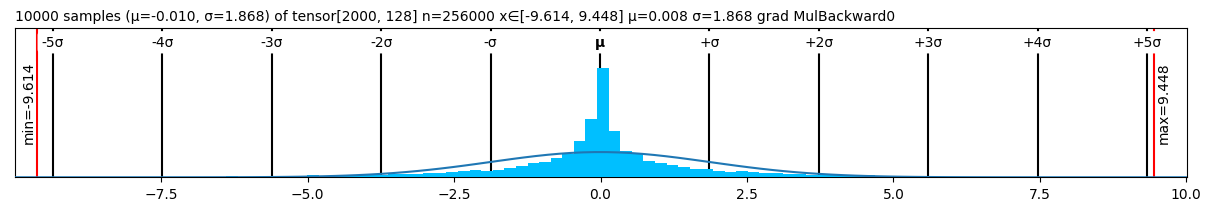

act_tanh (2000, 1) in [-0.999, 1.000] μ=-0.007 σ=0.693
act_sigmoid (2000, 1) in [0.002, 0.999] μ=0.505 σ=0.306
act_sin (2000, 1) in [-1.000, 1.000] μ=0.013 σ=0.707
act_cos (2000, 1) in [-1.000, 1.000] μ=0.007 σ=0.704


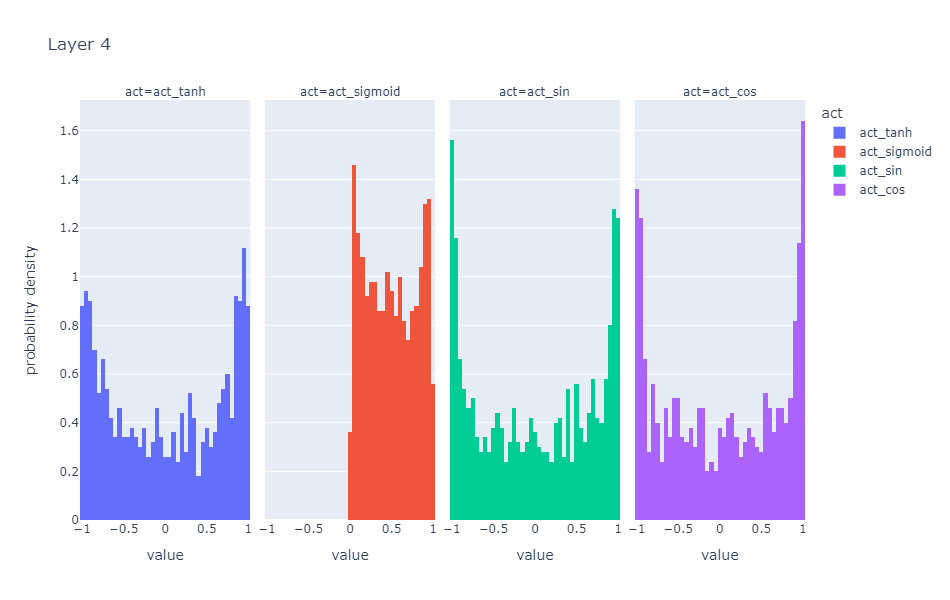

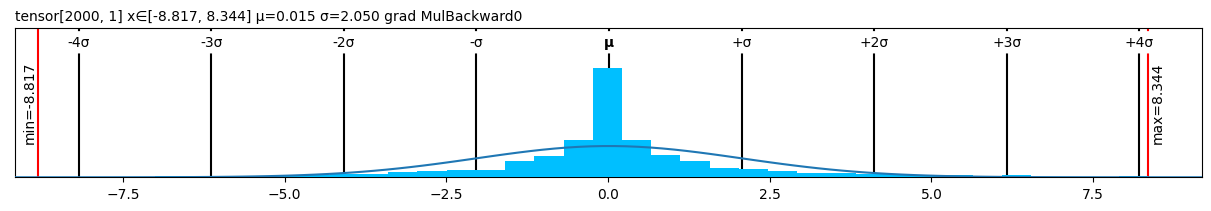

In [170]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    # if i >= 1:
    #     break

In [152]:
# x = U(2000, 2)
# o, intermediate_acts = model.forward_with_activations(x)

# for i, (h, acts) in enumerate(intermediate_acts):
#     plot_acts(acts, title=f'Layer {i}')
#     display(h.plt)

In [171]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

In [165]:
layers = {}

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    proposed_omegas_layer = {
        'G_tanh': omegas[i][0] / G_tanh.std(), 
        'G_sigmoid': omegas[i][1] / G_sigmoid.std(), 
        'G_sin': omegas[i][2] / G_sin.std(), 
        'G_cos': omegas[i][3] / G_cos.std()
    }
    
    print( [v.item() for v in (proposed_omegas_layer.values())] )

[0.12014468014240265, 0.6008497476577759, 0.2702421545982361, 0.2616932690143585]
[0.5118758678436279, 1.9711511135101318, 0.7647950053215027, 0.7527167201042175]
[2.7775514125823975, 9.462844848632812, 3.237828016281128, 3.223662853240967]
[18.891096115112305, 60.468223571777344, 18.257936477661133, 18.576128005981445]
[12.317709922790527, 39.97261428833008, 11.623711585998535, 11.119503021240234]


G_tanh (128, 128) in [-3.688, 3.349] μ=0.010 σ=0.932
G_sigmoid (128, 128) in [-3.462, 3.958] μ=0.008 σ=0.920
G_sin (128, 128) in [-3.931, 3.403] μ=0.003 σ=0.945
G_cos (128, 128) in [-3.541, 3.488] μ=-0.001 σ=0.932


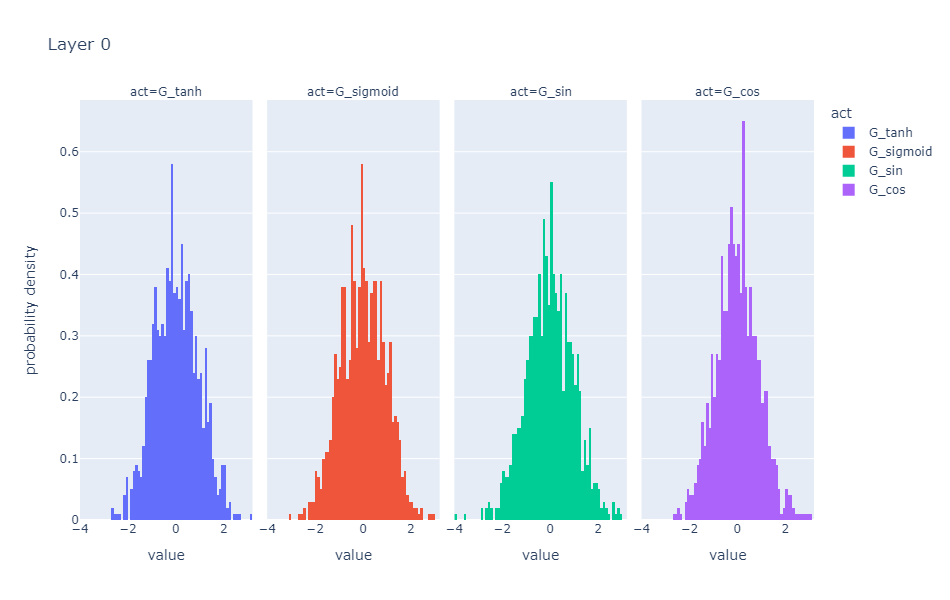

G_tanh (128, 128) in [-4.637, 5.528] μ=-0.000 σ=0.932
G_sigmoid (128, 128) in [-4.037, 4.917] μ=0.007 σ=0.937
G_sin (128, 128) in [-4.508, 3.924] μ=0.023 σ=0.956
G_cos (128, 128) in [-3.950, 4.267] μ=-0.014 σ=0.942


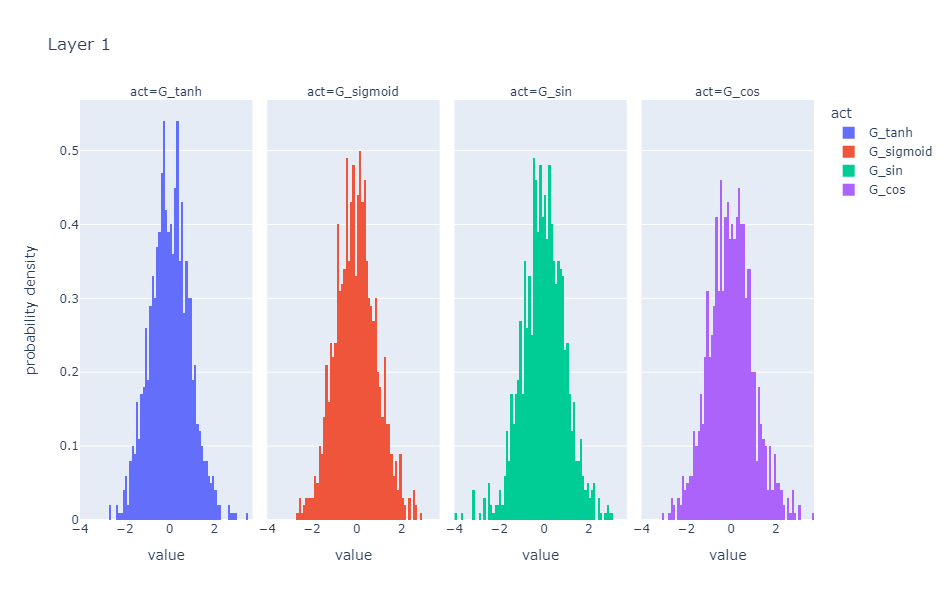

G_tanh (128, 128) in [-4.022, 3.659] μ=0.012 σ=0.922
G_sigmoid (128, 128) in [-3.654, 3.572] μ=-0.007 σ=0.929
G_sin (128, 128) in [-4.085, 4.455] μ=0.003 σ=0.941
G_cos (128, 128) in [-3.673, 4.064] μ=0.006 σ=0.927


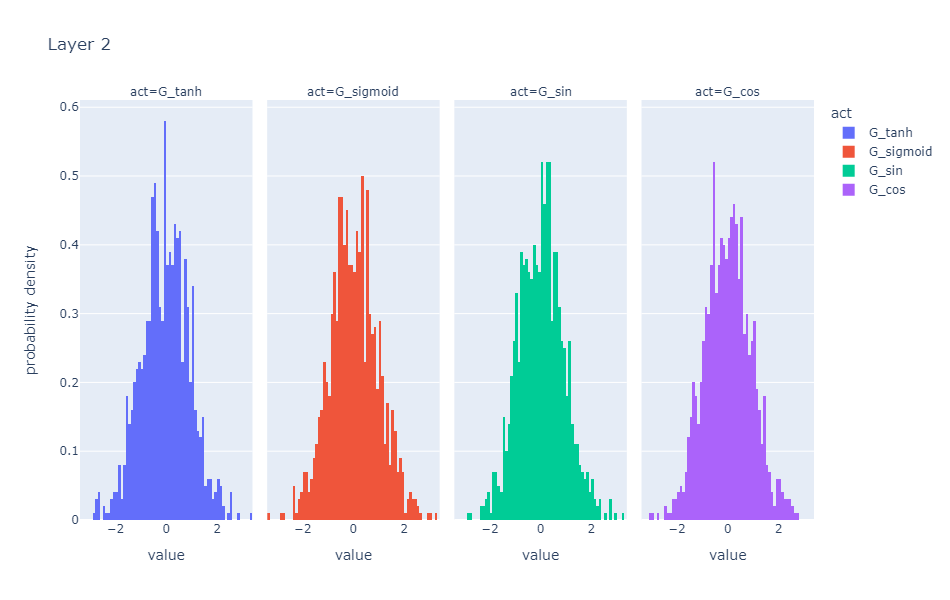

G_tanh (128, 128) in [-5.231, 4.370] μ=0.014 σ=0.934
G_sigmoid (128, 128) in [-5.071, 4.570] μ=0.004 σ=0.955
G_sin (128, 128) in [-5.054, 4.176] μ=0.003 σ=0.919
G_cos (128, 128) in [-5.360, 6.909] μ=-0.003 σ=0.932


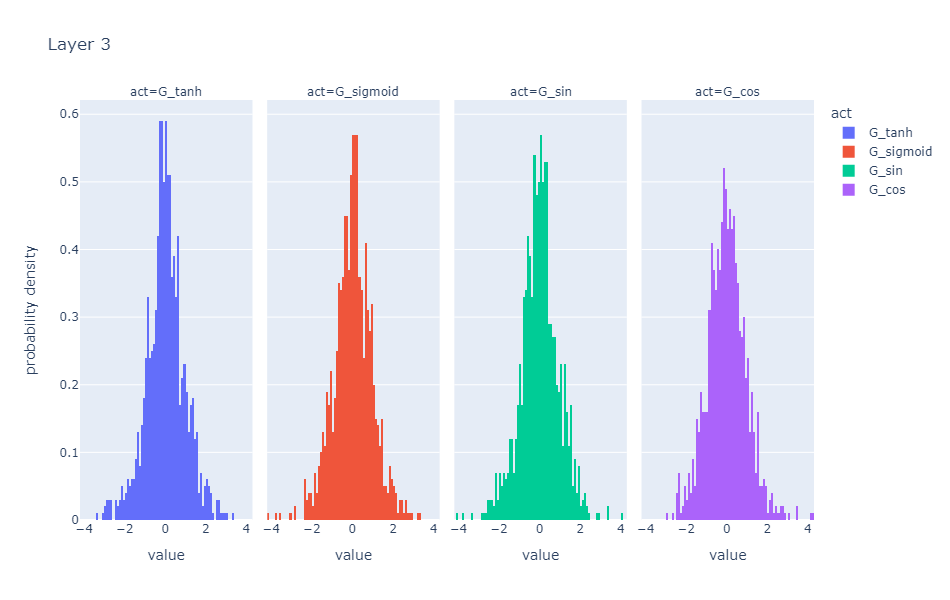

G_tanh (1, 128) in [-2.933, 2.286] μ=-0.066 σ=1.036
G_sigmoid (1, 128) in [-2.734, 2.481] μ=-0.000 σ=0.999
G_sin (1, 128) in [-2.952, 2.713] μ=0.088 σ=1.017
G_cos (1, 128) in [-2.904, 2.554] μ=-0.014 σ=0.937


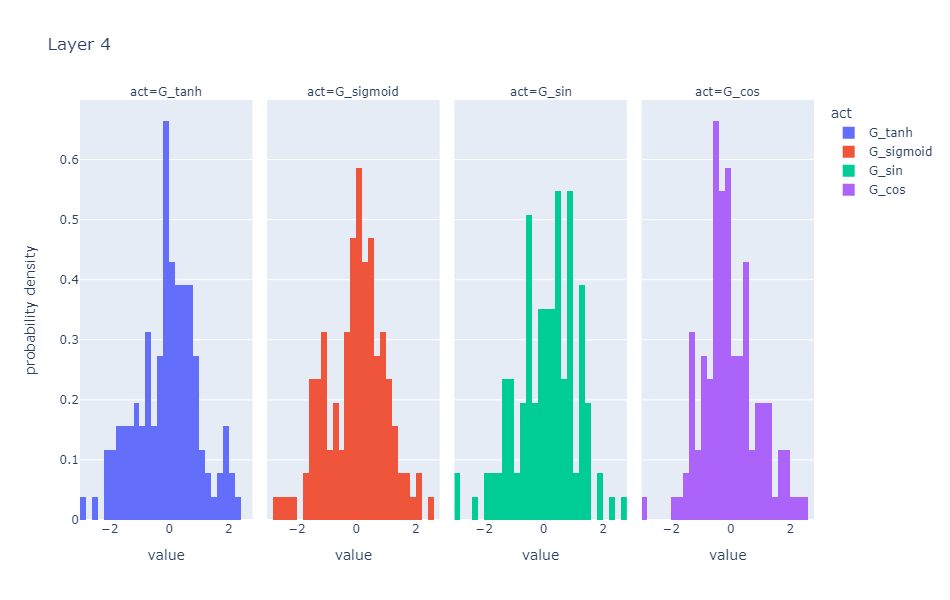

In [174]:

x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    plot_data = {
        'G_tanh': G_tanh, 
        'G_sigmoid': G_sigmoid, 
        'G_sin': G_sin, 
        'G_cos': G_cos
    }
    
    # for k,v in plot_data.items():
    #     print(k, v)
    
    plot_distributions(plot_data, title=f'Layer {i}')

    # if i >= 1:
    #     break

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} {tuple(G.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    plt.title(f'Layer {i} {tuple(G.shape)}');
    plt.show()


In [ ]:
break

In [ ]:
x_enc = model.encoding(x)
x_enc

In [ ]:
fan_in = 128

In [ ]:
omega=30
init_c=24
flic=2

c = np.sqrt(init_c / fan_in) / omega

In [ ]:
W = torch.zeros(fan_in, fan_in)
W.uniform_(-c, c)
W.plt

In [ ]:
(x_enc@(W*omega)).sin().plt

In [ ]:
acts = intermediate_acts[0]
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts[1]

In [ ]:
act_sin.plt

In [ ]:
o.plt

In [ ]:
for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    
